# D213: Advanced Data Analytics – Task 12 Sentiment Analysis using Neural Networks

## Part I: Research Question
### A1. Research Question
Is it possible to predict if an Amazon customer's review will be positive or negative on a product based on past reviews from other Amazon customers? 

### A2. Goal of the Analysis
The goal of this analysis is to build a neural network that is designed to use past reviews from other Amazon customers to predict the sentiments of a product.

### A3. Prescribed Network
I will be using is the Recurrent Neural Network(RNN) because not only is it beneficial for time series predictions, it also has an internal memory that is useful in remembering past reviews to make more accurate predictions (Donges, 2024). 

## Part II: Data Preparation
### B1. Data Exploration

In [1]:
# Import packages and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

from keras.utils import to_categorical

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.svm import SVC

import re

# Ignore warning code
import warnings
warnings.filterwarnings("ignore")

# Load the Amazon dataset by using read_csv command
df = pd.read_csv(r'C:\Users\ashle\Downloads\D213 Task 2\sentiment labelled sentences\amazon_cells_labelled.txt', 
                     delimiter='\t', header=None, names=['Reviews','Sentiment'])

# Explore the data
print(df.head())
print()
print("Shape of data:", df.shape)
print()
print(df.info())

                                             Reviews  Sentiment
0  So there is no way for me to plug it in here i...          0
1                        Good case, Excellent value.          1
2                             Great for the jawbone.          1
3  Tied to charger for conversations lasting more...          0
4                                  The mic is great.          1

Shape of data: (1000, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Reviews    1000 non-null   object
 1   Sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None


Sentiment
0    500
1    500
Name: count, dtype: int64


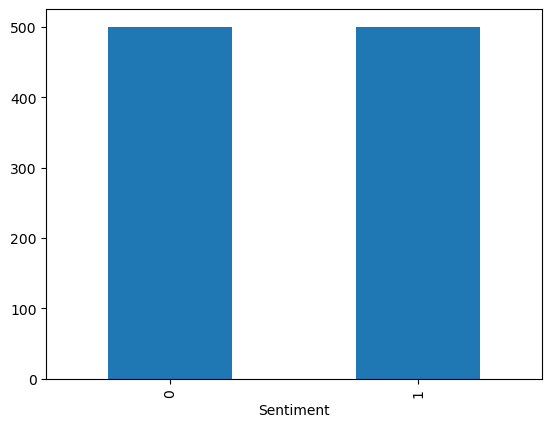

In [2]:
# Plot the sentiments  (0 = negative, 1 = positive)
print(df['Sentiment'].value_counts())
df['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [3]:
# Check for NaN
df.isna().sum()

Reviews      0
Sentiment    0
dtype: int64

In [4]:
# Drop any null values
df.dropna(inplace=True)
df.isnull().sum()

Reviews      0
Sentiment    0
dtype: int64

#### B1a. Presence of unusual characters (e.g., emojis, non-English characters)
The presence of unusual characters like uppercase letters, punctuations, emojis, and non-English characters need to be removed. The reason for the removal is to standardize the data, making it easier to analyze. The code and description of the code used can be found below:

In [5]:
# Identify the characters in the reviews column
commentary = df['Reviews']
list_of_characters = []
for comment in commentary: 
    for character in comment:
        if character not in list_of_characters:
            list_of_characters.append(character)
print(list_of_characters)

['S', 'o', ' ', 't', 'h', 'e', 'r', 'i', 's', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'U', 'I', 'b', 'c', 'v', '.', 'G', 'd', ',', 'E', 'x', 'j', 'T', '4', '5', 'M', 'A', 'J', 'O', 'R', 'P', 'B', 'L', '!', 'z', 'N', 'W', 'q', 'H', '+', 'V', '"', 'Y', 'D', 'F', 'k', "'", 'K', 'C', '/', '7', '3', '6', '8', '0', '2', '?', 'Z', '-', '1', ':', ')', '(', 'Q', '&', '$', '*', ';', 'X', '%', '9', '#', '[', ']']


In [6]:
# Remove the stop words, special characters, etc. (Elleh, n.d.)
description_list = []
stop_words = stopwords.words('english')
for description in df['Reviews']:
    
    # "^a-zA-Z" is filtering out any characters that are not in the alphabet
    description = re.sub("[^a-zA-Z]", " ", description) 

    # Convert the text to lowercase
    description = description.lower()

    # Perform tokenization    
    description = nltk.word_tokenize(description)

    # Perform lemmatization
    lemma = nltk.WordNetLemmatizer()
    description = [lemma.lemmatize(word) for word in description]
    
    # Remove the stop words    
    description = [word for word in description if not word in stop_words]
    description = " ".join(description)
    description_list.append(description)

In [7]:
# Create a dataframe from the description_list
clean_df = pd.DataFrame(description_list, columns=['Clean_Reviews'])

# Add the Sentiments column from the original dataframe to the new dataframe
clean_df = pd.concat([clean_df, df['Sentiment']], axis=1)

# Display the new dataframe
clean_df

,Clean_Reviews,Sentiment
0,way plug u unless go converter,0
1,good case excellent value,1
2,great jawbone,1
3,tied charger conversation lasting minute major...,0
4,mic great,1
...,...,...
995,screen doe get smudged easily touch ear face,0
996,piece junk lose call phone,0
997,item doe match picture,0
998,thing disappoint infra red port irda,0


#### B1b. Vocabulary Size
The vocabulary size is the number of unique words in the dataset. The vocabulary size calculated is 1,568.

In [8]:
# Calculate the vocabulary size -- this is the number of unique (tokenized) words in the dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_df['Clean_Reviews'])
vocab_size = len(tokenizer.word_index) + 1

# Print the vocabulary size
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 1568


#### B1c. Proposed Word Embedding Length
Word embeddings represent words as vectors in a specific space. Each word has one vector, and these vectors’ values are learned using methods similar to neural networks, linking this technique to deep learning (Brownlee, 2021). It is calculated by calculating the "fourth root" of the vocabulary size. This is the squared root of the square root. Therefore, the proposesd word embedding length is 6.

In [9]:
# Calculate the lengths of all review sequences
review_length = []
for char_len in clean_df['Clean_Reviews']:
    review_length.append(len(char_len.split(" ")))

max_length = np.max(review_length)
median_length = np.median(review_length)
min_length = np.min(review_length)

print("The maximum length of our sequences is:", max_length)
print("The median length of our sequences is:", median_length)
print("The minimum length of our sequences is:", min_length)

The maximum length of our sequences is: 17
The median length of our sequences is: 4.0
The minimum length of our sequences is: 1


In [10]:
# Calculate the proposed word embedding length 
embed_size = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
embed_size

6

#### B1d. Statistical Justification for the Chosen Maximum Sequence Length
The maximum sequence length is the review with the highest number of words in the Amazon datset. The reason the maximum sequence length is chosen is to help ensure the model uses all available input data, which leads to better conclusions. If some inputs are shorter than this maximum length, we can add padding to make them fit. The chosen maximum sequence length is 17.

In [11]:
# The code shown in part B1c shows the statistical justification of the maximum length of sequences
print("Max length: ", max_length)

Max length:  17


### B2. Tokenization
For the analysis, tokenization was used to determine the vocabulary size by determining the number of unique (tokenized) words in the dataset. The method was imported from the following: "from tensorflow.keras.preprocessing.text import Tokenizer". Refer to part B1b for tokenization code. Tokenization is the process of breaking down the unstructured text into smaller units called tokens. These tokens could be words, punctuation marks, sentences, etc. The goal is to remove any unusual characters, stopwords, and break down the text to make it easier for machines to process the information without losing its meaning (Awan, 2024).

### B3. Padding Process
Padding is a process used to standardize the sequence length by adding characters (spaces, zeros, etc.) to string data to make them all the same length. This process was imported from the following: "from tensorflow.keras.preprocessing.sequence import pad_sequences". The padding occurs after the text sequence.

In [12]:
# Apply padding to description_list
sequences = tokenizer.texts_to_sequences(description_list)
padded_seq = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Display the padded sequence
padded_seq

array([[ 132,   78,  430, ...,    0,    0,    0],
       [   5,   15,   21, ...,    0,    0,    0],
       [   2,  314,    0, ...,    0,    0,    0],
       ...,
       [  37,   24,  349, ...,    0,    0,    0],
       [  57, 1564, 1565, ...,    0,    0,    0],
       [ 657,   29,  116, ...,    0,    0,    0]])

In [13]:
# Print an example of a single padded sequence
to_words = tokenizer.sequences_to_texts(padded_seq)
to_words[5]

print(padded_seq[5])
print(description_list[5])
print(to_words[5])

[671  78  20 189  79  20 248  80   0   0   0   0   0   0   0   0   0]
jiggle plug get line right get decent volume
jiggle plug get line right get decent volume


### B4. Categories of Sentiment
The sentiment column in the Amazon dataset has two values, 0 and 1. The negative sentiment is represented by "0" and the positive sentiment is represented by "1". Therefore, the sigmoid activation function will be used since it is primarily used for classifying binary categories.

### B5. Data Preparation Steps
1. Import packages and libraries.
2. Load the amazon dataset by using read_csv command.
3. Explore the data.
4. Clean the data.
5. Remove the stop words, special characters, etc from the reviews column.
6. Identify the vocabulary size, the number of unique (tokenized) words in the dataset.
7. Find the proposed word embedding length.
8. Perform tokenization on the data.
9. Apply padding to the data.
10. Determine the number of sentiment categories.
11. Perform the sigmoid activation function in a neural network.
12. Split the data into training and testing sets with an 80/20 split.
13. Save the training sets, testing sets, and cleaned dataframe as csv files.

In [14]:
# Split the data into training and testing sets
padded_X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
X= padded_X
y = clean_df['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

# Convert the categorical data into a format suitable for machine learning by one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

In [15]:
# Print the training and testing sizes
print("X_train Size:",X_train.shape)
print("X_test Size:",X_test.shape)
print("y_train Size:",y_train_cat.shape)
print("y_test Size:",y_test_cat.shape)

X_train Size: (800, 17)
X_test Size: (200, 17)
y_train Size: (800, 2)
y_test Size: (200, 2)


### B6. Prepared Data
The testing and training sets, as well as the cleaned dataframe, will be attached to the submission as the csv files listed below.

In [16]:
# Create dataframes of the testing and training sets
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train_cat)
y_test_df = pd.DataFrame(y_test_cat)

# Export the dataframes as csv files
pd.DataFrame(X_train_df).to_csv('X_train_df.csv')
pd.DataFrame(X_test_df).to_csv('X_test_df.csv')
pd.DataFrame(y_train_df).to_csv('y_train_df.csv')
pd.DataFrame(y_test_df).to_csv('y_test_df.csv')

# Export the cleaned dataframe as a csv file
pd.DataFrame(clean_df).to_csv('clean_df_D213_task2.csv')

## Part III: Network Architecture
### C1. Model Summary

In [17]:
# Perform the sigmoid activation function
loss = 'binary_crossentropy'
optimizer = 'adam' 

# Define early stopping monitor 
early_stopping_monitor = EarlyStopping(patience=2)

# Create a sequential model
model = Sequential()

# Add layers using the add() method
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(int(X_train.shape[1]),)),
    tf.keras.layers.Embedding(vocab_size, max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [18]:
# Print the model summary 
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 17, 17)         │        26,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 17)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,557 (131.08 KB)

 Trainable params: 33,557 (131.08 KB)

 Non-trainable params: 0 (0.00 B)

### C2. Network Architecture
The network created is made up of five layers and 33,557 trainable parameters. The layer types as well as their parameters can be found below:
* Layer 1: Embedding layer, parameters - 26,656
* Layer 2: Global Average layer, parameters - 0
* Layer 3: Dense layer, parameters - 1,800
* Layer 4: Dense layer, parameters - 5,050
* Layer 5: Dense layer, parameters - 51

### C3. Hyperparameters
#### C3a. Activation Functions
There are three dense layers in my model that need an activation function. I chose to use the sigmoid activation function since it is best used with binary classification data.

#### C3b. Number of Nodes Per Layer
I started with one hidden layer and then added another to see if it would improve the accuracy. After re-running the model  multiple times, I determined the first hidden dense layer has 100 nodes, the second has 50 nodes, and the output has 1 node for the binary class. 

#### C3c. Loss Function
I chose to use the binary cross entropy loss function since the sentiment column of the dataset already has values of 0 and 1. Binary cross entropy gives a probability value within 0 and 1. Values closer to 1 represent the positive sentiment (Tannor, 2024).

#### C3d. Optimizer
The optimizer chosen for the network was the Adam optimizer. The Adam optimizer is a commonly used algorithm used in deep learning that modifies the network's characteristics to improve the accuracy and reduces the loss (Ayush, 2024).

#### C3e. Stopping Criteria
The stopping criteria used was early_stopping_monitor determined by the number of patience. This will stop the training process once the validation loss starts to increase to prevent overfitting. I chose 2 to be the value of patience because 2 or 3 is typically is a good value. I also chose a maximum number of 10 epochs, or training iterations (Elleh, n.d.).

#### C3f. Evaluation Metric
The evaluation metric chosen is accuracy. The code and further discussion can be found under part D2.

## Part IV: Model Evaluation
### D1. Stopping Criteria
As already mentioned in part C3e, the stopping criteria used was early_stopping_monitor determined by the number of patience. This will stop the training process once the validation loss starts to increase to prevent overfitting. I chose 2 to be the value of patience because 2 or 3 is typically is a good value. I originally chose a maximum number of 20 epochs, or training iterations. However, after trial and error, I came to the conclusion to change the maximum number to 10 because it had less loss and higher accuracy. The model can stop before 10 epochs though if all conditions are internally satisfied. The final training epoch is shown below.

In [19]:
# Train the model
history = model.fit(X_train, y_train, batch_size=50, epochs=10, validation_split = 0.3,
                    callbacks=[early_stopping_monitor], verbose=True)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5279 - loss: 0.6932 - val_accuracy: 0.6375 - val_loss: 0.6926
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.6916 - val_accuracy: 0.5083 - val_loss: 0.6914
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5863 - loss: 0.6899 - val_accuracy: 0.5125 - val_loss: 0.6894
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5311 - loss: 0.6830 - val_accuracy: 0.6208 - val_loss: 0.6845
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8221 - loss: 0.6706 - val_accuracy: 0.7458 - val_loss: 0.6727
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8570 - loss: 0.6468 - val_accuracy: 0.8083 - val_loss: 0.6518
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9186 - loss: 0.6037 - val_accuracy: 0.6250 - val_loss: 0.6267
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8012 - loss: 0.5530 - val_accuracy: 0.7000 - val_loss

### D2. Fitness
Overfitting can occur if the model remembers too much information from the training set to where it cannot adjust to the testing data. I nearly suffered from overfitting when running the code above. I realized I had to reduce the number of epochs from 20 to 10 to prevent overfitting. Once corrected, the model accuracy is now 74.5%. According to Dr. Sewell's video presentation, this is a good model accuracy since it is nearing 80% and the validation accuracy is about 80% too on the last iteration. The training model accuracy is 90.13%.

In [20]:
# Print the model accuracy on test data
score = model.evaluate(X_test, y_test, verbose=0)

print('Final Model Loss: ', round(score[0],5))
print('Final Model Accuracy: ', round(score[1]*100, 2),'%')

Final Model Loss:  0.52805
Final Model Accuracy:  74.5 %


In [21]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Training Final Model Accuracy: ', round(score[1]*100, 2),'%')

Training Final Model Accuracy:  90.13 %


### D3. Training Process

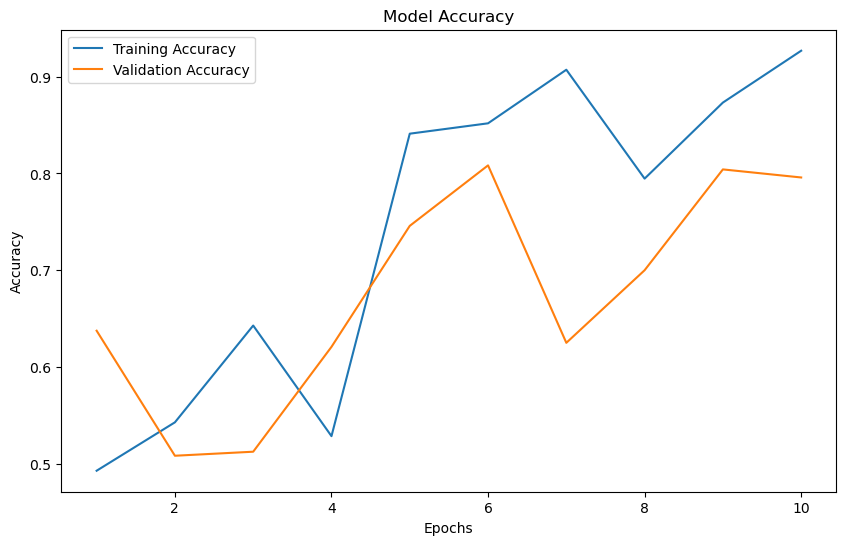

In [22]:
# Define the accuracy and loss of the training history
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

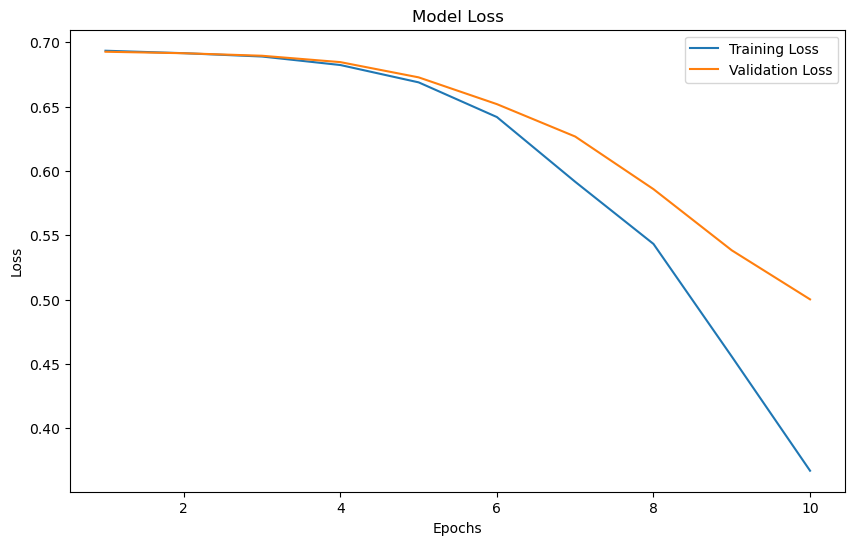

In [23]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### D4. Predictive Accuracy
The predictive accuracy of the model was 74.5% which shows the model can accurately predict 74.5% of the training data. The final model loss was 0.52805. According to the heatmap shown below, the model correctly predicted a positive sentiment represented by 1, 60 out of 106 reviews and predicted a negative sentiment represented by 0, correctly 57 out of 94 reviews.

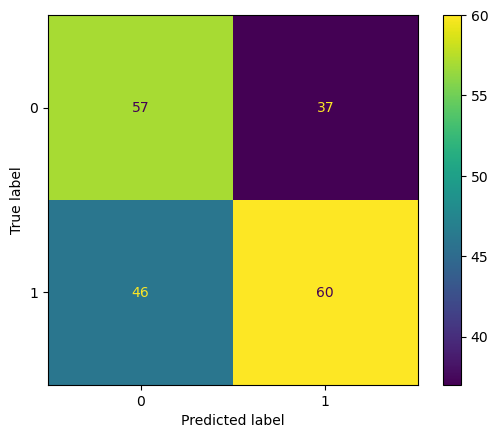

In [24]:
# Create the confusion matrix
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)  
disp.plot()
plt.show()

## Part V: Summary & Recommendations
### E. Code

In [25]:
# Save the trained model
model.save('D213_trained_model.keras')

### F. Functionality
The provided dataset has 1,000 Amazon customer reviews and their sentiments labelled as 0 and 1. The model was trained on 80% of the data (training set) and the other 20% was used for testing the performance of the model (testing set). The model was able to accurately predict 90.13% of the training set and 74.5% of the testing set. 

The network architecture of the model was used for sentiment analysis. The network architecture was constructed by trial and error, depending on the accuracy and amount of loss by starting with one hidden layer and then added another to see if it would improve the accuracy. Once I got an acceptable accuracy, this helped detect the sentiment of the Amazon customer reviews. The layers and the type of activation function used in each layer was chosen based on the binary data being tested on (postive/negative sentiments). The architecture determines how the model learns patterns from the data, allowing it to perform classification on the reviews.

### G. Recommendations
According to the predicitive accuracy calculated, it is possible to construct a neural network to predict if an Amazon customer's review will be positive or negative on a product based on past reviews from other Amazon customers since it had good functionality as show in part F. The model can be used to predict the sentiments and analyze the trends to improve customer satisfaction. My recommendation is to provide more customer reviews. Neural networks generally perform better with larger datasets since they were created to analyze and learn complex patterns, but make sure the data quality is sufficient because that can affect the model's performance.

## Part VI: Reporting
### H. Reporting
An HTML file has been attached to the submission as "D213_Task2.html"

### I. Sources for Third-Party Code
Elleh, F. D213 Task 2 Cohort Webinar [PowerPoint Slides].

D213 Sentiment Analysis Presentation _ 3_default_da1cc82b [Webinar]. WGU. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=fe172002-6cbb-40c0-92a3-b07d01025504

### J. Sources
Donges, N. (2024b, October 17). What are recurrent neural networks (rnns)?. Built In. https://builtin.com/data-science/recurrent-neural-networks-and-lstm#:~:text=recurrent%20neural%20network%3F-,A%20recurrent%20neural%20network%20(RNN)%20is%20a%20type%20of%20neural,inputs%2C%20learning%20from%20past%20experiences. 

Awan, A. A. (2024, November 22). What is tokenization? types, use cases, implementation. DataCamp. https://www.datacamp.com/blog/what-is-tokenization 

Tannor, P. (2024, June 25). What is binary cross entropy? calculation & its significance. Deepchecks. https://www.deepchecks.com/glossary/binary-cross-entropy/#:~:text=Binary%20Cross%20Entropy%20is%20a,0%20for%20its%20negative%20counterpart. 

Ayush. (2024, December 10). Optimizers in Deep learning: A detailed guide. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#:~:text=While%20training%20the%20deep%20learning,overall%20loss%20and%20improving%20accuracy. 

Brownlee, J. (2021, Feb 02). How to use word embedding layers for deep learning with keras. https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/ 
https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html